# Khái niệm cơ bản về Structured Streaming
Structured Streaming, như chúng ta đã thảo luận ở cuối Chương 20, là một quá trình xử lý luồng khung được xây dựng trên công cụ Spark SQL. Thay vì giới thiệu một API riêng biệt, Structured Streaming sử dụng các API có cấu trúc hiện có trong Spark (DataFrames, Datasets và SQL), nghĩa là rằng tất cả các thao tác bạn quen thuộc với ở đó đều được hỗ trợ. Người dùng thể hiện một luồng tính toán giống như cách họ viết tính toán hàng loạt trên dữ liệu tĩnh. Sau khi chỉ định điều này và chỉ định đích phát trực tuyến, công cụ Structured Streaming sẽ xử lý chạy truy vấn của bạn tăng dần và liên tục khi dữ liệu mới được đưa vào hệ thống.

## Input Sources
Structured Streaming hỗ trợ một số nguồn đầu vào để đọc theo kiểu truyền trực tuyến. Kể từ Spark 2.2, các nguồn đầu vào được hỗ trợ như sau:
1. Apache Kafka 0.10
2. Các tệp trên hệ thống tệp phân tán như HDFS hoặc S3 (Spark sẽ liên tục đọc mới các tệp trong một thư mục)
3. Một nguồn ổ cắm để thử nghiệm

## Sinks
Cũng giống như các nguồn cho phép bạn lấy dữ liệu vào Structured Streaming, Sinks chỉ định đích cho
tập kết quả của luồng đó. Sinks và quá trình thực thi cũng chịu trách nhiệm về
theo dõi tiến độ xử lý dữ liệu chính xác. Dưới đây là các đầu ra được hỗ trợ Sinks kể từ Spark 2.2:
1. Apache Kafka 0.10
2. Hầu hết mọi định dạng tệp
3. Một foreach Sink để chạy tính toán trọng tài trên các bản ghi đầu ra
4. Một console Sink để thử nghiệm
5. Bộ memory Sink để debug

## Output Modes
Xác định Sinks cho công việc Structured Streaming chỉ là một nửa của câu chuyện. Chúng ta cũng cần xác định
cách chúng ta muốn Spark ghi dữ liệu vào Sinks. Ví dụ: chúng ta chỉ muốn nối thêm
thông tin? Chúng ta có muốn cập nhật các hàng khi nhận được thêm thông tin về chúng theo thời gian không
(ví dụ: cập nhật số lần nhấp cho một trang web nhất định)? Chúng ta có muốn ghi đè hoàn toàn
kết quả được đặt mỗi lần (tức là luôn viết một tệp với số lần nhấp hoàn chỉnh cho tất cả các trang)?

Để làm điều này, chúng tôi xác định một chế độ đầu ra, tương tự như cách chúng tôi xác định các chế độ đầu ra trong static
Structured APIs.
Các chế độ đầu ra được hỗ trợ như sau:
1. Nối (chỉ thêm các bản ghi mới vào output sink)
2. Cập nhật (cập nhật các bản ghi đã thay đổi tại chỗ)
3. Hoàn thành (viết lại đầu ra đầy đủ)

Một chi tiết quan trọng là một số truy vấn nhất định và một số sink nhất định, chỉ hỗ trợ một số chế độ đầu ra nhất định,
như chúng ta sẽ thảo luận ở phần sau của cuốn sách. Ví dụ: giả sử rằng công việc của bạn chỉ là biểu diễn một map
trên stream. Dữ liệu đầu ra sẽ phát triển vô thời hạn khi các bản ghi mới đến, vì vậy nó sẽ không làm
sử dụng chế độ Hoàn thành, chế độ này yêu cầu ghi tất cả dữ liệu vào một tệp mới cùng một lúc. Ngược lại,
nếu bạn đang tổng hợp thành một số khóa giới hạn, các chế độ Hoàn thành và Cập nhật
sẽ hợp lý, nhưng Nối thì không, vì giá trị của một số khóa cần được cập nhật
tăng ca.

## Triggers
Trong khi các chế độ đầu ra xác định cách dữ liệu được xuất ra, thì trình kích hoạt xác định khi nào dữ liệu được xuất ra — nghĩa là
khi Structured Streaming nên kiểm tra dữ liệu đầu vào mới và cập nhật kết quả của nó. Theo mặc định,
Structured Streaming sẽ tìm kiếm các bản ghi đầu vào mới ngay sau khi nó hoàn tất quá trình xử lý cuối cùng
nhóm dữ liệu đầu vào, tạo độ trễ thấp nhất có thể cho các kết quả mới. Tuy nhiên, hành vi này
có thể dẫn đến việc ghi nhiều tệp đầu ra nhỏ khi phần chìm là một tập hợp các tệp. Do đó, Spark cũng
hỗ trợ kích hoạt dựa trên thời gian xử lý (chỉ tìm kiếm dữ liệu mới ở một khoảng thời gian cố định). bên trong
trong tương lai, các loại trình kích hoạt khác cũng có thể được hỗ trợ.

### Event-Time Processing
Structured Streaming cũng hỗ trợ xử lý theo thời gian sự kiện (tức là xử lý dữ liệu dựa trên
dấu thời gian có trong bản ghi có thể không đúng thứ tự). Có hai ý tưởng chính mà bạn
sẽ cần phải hiểu ở đây vào lúc này; chúng ta sẽ nói về cả hai điều này trong nhiều hơn nữa
chiều sâu của chương tiếp theo, vì vậy đừng lo lắng nếu bạn chưa hiểu rõ về chúng tại thời điểm này.

#### Watermarks
Watermarks là một tính năng của hệ thống phát trực tuyến cho phép bạn chỉ định mức độ trễ mà họ mong đợi
xem dữ liệu trong thời gian sự kiện. Ví dụ: trong một ứng dụng xử lý nhật ký từ thiết bị di động,
người ta có thể mong đợi nhật ký trễ đến 30 phút do tải lên chậm trễ.

# Structured Streaming in Action
Hãy xem một ví dụ áp dụng về cách bạn có thể sử dụng Structured Streaming. Đối với các ví dụ của chúng tôi,
chúng tôi sẽ làm việc với Tập dữ liệu ghi nhận hoạt động của con người không đồng nhất. Các
dữ liệu bao gồm các chỉ số cảm biến trên điện thoại thông minh và đồng hồ thông minh từ nhiều thiết bị—
cụ thể là gia tốc kế và con quay hồi chuyển, được lấy mẫu ở tần số cao nhất có thể
được hỗ trợ bởi các thiết bị. Các bài đọc từ các cảm biến này được ghi lại trong khi người dùng thực hiện
các hoạt động như đi xe đạp, ngồi, đứng, đi bộ, v.v. Có một số khác nhau
điện thoại thông minh và đồng hồ thông minh được sử dụng và tổng số chín người dùng.

In [1]:
print(1)

1


In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
# sc = SparkContext.getOrCreate('local')
spark = SparkSession(sc)

In [4]:
static = spark.read.json("../data/activity-data/")
dataSchema = static.schema

In [5]:
static.printSchema()

root
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- Device: string (nullable = true)
 |-- Index: long (nullable = true)
 |-- Model: string (nullable = true)
 |-- User: string (nullable = true)
 |-- gt: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



In [6]:
static.show(4)

+-------------+-------------------+--------+-----+------+----+-----+------------+------------+------------+
| Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|           x|           y|           z|
+-------------+-------------------+--------+-----+------+----+-----+------------+------------+------------+
|1424686735090|1424686733090638193|nexus4_1|   18|nexus4|   g|stand| 3.356934E-4|-5.645752E-4|-0.018814087|
|1424686735292|1424688581345918092|nexus4_2|   66|nexus4|   g|stand|-0.005722046| 0.029083252| 0.005569458|
|1424686735500|1424686733498505625|nexus4_1|   99|nexus4|   g|stand|   0.0078125|-0.017654419| 0.010025024|
|1424686735691|1424688581745026978|nexus4_2|  145|nexus4|   g|stand|-3.814697E-4|   0.0184021|-0.013656616|
+-------------+-------------------+--------+-----+------+----+-----+------------+------------+------------+
only showing top 4 rows



Tiếp theo, hãy tạo một phiên bản streaming của cùng một Tập dữ liệu, phiên bản này sẽ đọc từng tệp đầu vào trong tập dữ liệu từng cái một như thể nó là một luồng. Streaming DataFrames phần lớn giống như DataFrames tĩnh.

Tuy nhiên, một điểm khác biệt nhỏ là Streaming DataFrames không cho phép bạn thực hiện perform schema mà không bật nó một cách rõ ràng. Bạn có thể bật suy luận giản đồ cho điều này bằng cách đặt cấu hình spark.sql.streaming.schemaInference thành True. Được thực tế là, chúng tôi sẽ đọc lược đồ từ một tệp (mà chúng tôi biết có một lược đồ hợp lệ) và chuyển đối tượng dataSchema từ DataFrame tĩnh sang DataFrame trực tuyến của chúng tôi. Như đã đề cập, bạn nên tránh làm điều này trong một kịch bản sản xuất mà dữ liệu của bạn có thể (vô tình) thay đổi từ dưới bạn:

In [10]:
streaming = spark.readStream.schema(dataSchema).option("maxFilesPerTrigger", 1)\
.json("../data/activity-data")

Cũng giống như với các API Spark khác, việc tạo và thực thi streaming DataFrame là lazy. Đặc biệt, bây giờ chúng tôi có thể chỉ định các chuyển đổi trên streaming DataFrame của chúng tôi trước khi gọi một hành động để bắt đầu luồng. Trong trường hợp này, chúng tôi sẽ chỉ ra một chuyển đổi đơn giản — chúng tôi sẽ nhóm và đếm dữ liệu theo cột gt, là hoạt động đang được thực hiện bởi người dùng tại đó đúng lúc:

In [11]:
activityCounts = streaming.groupBy("gt").count()
activityCounts

DataFrame[gt: string, count: bigint]

Vì mã này đang được viết ở chế độ cục bộ trên một máy nhỏ, chúng tôi sẽ thiết lập
xáo trộn phân vùng thành một giá trị nhỏ để tránh tạo quá nhiều phân vùng xáo trộn:

In [12]:
spark.conf.set("spark.sql.shuffle.partitions", 5)

Bây giờ chúng ta đã thiết lập chuyển đổi, chúng ta chỉ cần chỉ định hành động của mình để bắt đầu truy vấn. Như
đã đề cập trước đó trong chương, chúng tôi sẽ chỉ định một ouput hoặc output Sink cho
kết quả của truy vấn này. Đối với ví dụ cơ bản này, chúng ta sẽ ghi vào một bộ nhớ lưu giữ
bảng kết quả trong bộ nhớ.

Trong quá trình chỉ định phần chìm này, chúng tôi sẽ cần xác định cách Spark sẽ xuất ra
dữ liệu. Trong ví dụ này, chúng tôi sử dụng chế độ đầu ra hoàn chỉnh. Chế độ này sẽ viết lại tất cả các phím cùng
với số lượng của họ sau mỗi lần kích hoạt:

In [13]:
activityQuery = activityCounts.writeStream.queryName("activity_counts")\
.format("memory").outputMode("complete")\
.start()

Chúng tôi hiện đang viết ra luồng của chúng tôi! Bạn sẽ nhận thấy rằng chúng tôi đặt một tên truy vấn duy nhất để đại diện
luồng này, trong trường hợp này là activity_counts. Chúng tôi đã chỉ định định dạng của mình dưới dạng bảng trong bộ nhớ và
chúng tôi đặt chế độ đầu ra.

Khi chúng tôi chạy mã trước, chúng tôi cũng muốn bao gồm dòng sau:

In [19]:
# activityQuery.awaitTermination()
activityQuery.stop()

Sau khi mã này được thực thi, tính toán phát trực tuyến sẽ bắt đầu ở chế độ nền. Các
đối tượng truy vấn là một xử lý đối với truy vấn phát trực tuyến đang hoạt động đó và chúng tôi phải chỉ định rằng chúng tôi muốn
đợi kết thúc truy vấn bằng cách sử dụng activityQuery.awaitTermination () để ngăn chặn
trình điều khiển thoát khỏi quá trình thoát khi truy vấn đang hoạt động. Chúng tôi sẽ bỏ qua điều này trong các phần tương lai của chúng tôi
của cuốn sách để dễ đọc, nhưng nó phải được đưa vào ứng dụng sản xuất của bạn; nếu không thì,
luồng của bạn sẽ không thể chạy.

Spark liệt kê luồng này và các luồng đang hoạt động khác, dưới các luồng đang hoạt động trong SparkSession của chúng tôi. Chúng tôi
có thể xem danh sách các luồng đó bằng cách chạy như sau:

In [22]:
list(spark.streams.active)

In [21]:
from time import sleep
for x in range(5):
    spark.sql("SELECT * FROM activity_counts").show()
    sleep(1)

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|36929|
|     stand|34154|
|stairsdown|28094|
|      walk|39768|
|  stairsup|31357|
|      null|31343|
|      bike|32390|
+----------+-----+

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|36929|
|     stand|34154|
|stairsdown|28094|
|      walk|39768|
|  stairsup|31357|
|      null|31343|
|      bike|32390|
+----------+-----+

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|36929|
|     stand|34154|
|stairsdown|28094|
|      walk|39768|
|  stairsup|31357|
|      null|31343|
|      bike|32390|
+----------+-----+

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|36929|
|     stand|34154|
|stairsdown|28094|
|      walk|39768|
|  stairsup|31357|
|      null|31343|
|      bike|32390|
+----------+-----+

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|36929|
|     stand|34154|
|stairsdown|28094|
|      walk|39768|
|  stairsup|31357|
|      n

# Chuyển đổi trên Luồng
Các phép chuyển đổi luồng, như chúng tôi đã đề cập, bao gồm hầu hết tất cả các DataFrame tĩnh
các phép biến đổi mà bạn đã thấy trong Phần II. Tất cả các lựa chọn, bộ lọc và chuyển đổi đơn giản đều
được hỗ trợ, cũng như tất cả các chức năng DataFrame và các thao tác cột riêng lẻ. Những hạn chế
nảy sinh trên các chuyển đổi không có ý nghĩa trong bối cảnh truyền dữ liệu. Ví dụ, kể từ
Apache Spark 2.2, người dùng không thể sắp xếp các luồng không được tổng hợp và không thể thực hiện
nhiều cấp độ tổng hợp mà không sử dụng Xử lý trạng thái (được đề cập trong chương trình tiếp theo).
Những hạn chế này có thể được dỡ bỏ khi Structured Streaming tiếp tục phát triển, vì vậy chúng tôi khuyến khích
bạn kiểm tra tài liệu về phiên bản Spark của mình để biết các bản cập nhật.

## Selections and Filtering
Tất cả các chuyển đổi bộ lọc và lựa chọn đều được hỗ trợ trong Structured Streaming, cũng như tất cả DataFrame
chức năng và các thao tác cột riêng lẻ. Chúng tôi đưa ra một ví dụ đơn giản bằng cách sử dụng các Selections and Filtering bên dưới. Trong trường hợp này, vì chúng tôi không cập nhật bất kỳ khóa nào theo thời gian, chúng tôi sẽ sử dụng
Thêm chế độ đầu ra, để kết quả mới được nối vào bảng đầu ra:

In [24]:
from pyspark.sql.functions import expr
simpleTransform = streaming.withColumn("stairs", expr("gt like '%stairs%'"))\
.where("stairs")\
.where("gt is not null")\
.select("gt", "model", "arrival_time", "creation_time")\
.writeStream\
.queryName("simple_transform1")\
.format("memory")\
.outputMode("append")\
.start()

## Aggregations
Truyền trực tuyến có cấu trúc hỗ trợ tuyệt vời cho việc tổng hợp. Bạn có thể chỉ định tùy ý
tổng hợp, như bạn đã thấy trong API có cấu trúc. Ví dụ: bạn có thể sử dụng một
tổng hợp, như một khối lập phương, trên kiểu điện thoại và hoạt động cũng như gia tốc x, y, z trung bình của
cảm biến của chúng tôi (quay lại Chương 7 để xem các tổng hợp tiềm năng mà bạn có thể chạy trên
luồng của bạn):

In [26]:
deviceModelStats = streaming.cube("gt", "model").avg()\
.drop("avg(Arrival_time)")\
.drop("avg(Creation_Time)")\
.drop("avg(Index)")\
.writeStream.queryName("device_counts1").format("memory")\
.outputMode("complete")\
.start()

In [29]:
spark.sql('SELECT * FROM device_counts1').show()

+----------+------+--------------------+--------------------+--------------------+
|        gt| model|              avg(x)|              avg(y)|              avg(z)|
+----------+------+--------------------+--------------------+--------------------+
|       sit|  null|-4.92132825379802...|3.757376157445754...|-4.42863346250723E-5|
|     stand|  null|-3.00989804137386...|4.133303473120163...|-2.86960196767408...|
|       sit|nexus4|-4.92132825379802...|3.757376157445754...|-4.42863346250723E-5|
|     stand|nexus4|-3.00989804137386...|4.133303473120163...|-2.86960196767408...|
|      null|  null|-0.00302501221506...|-0.00410754501410...|0.005961452067049526|
|      null|  null|0.002921030154575...|-0.00836616384160...|-0.00897552622204...|
|      walk|  null|0.001970352086338...|7.489666845955465E-5|-0.00149828380428...|
|      null|nexus4|-0.00302501221506...|-0.00410754501410...|0.005961452067049526|
|      null|nexus4|0.002921030154575...|-0.00836616384160...|-0.00897552622204...|
|   

Ngoài các tổng hợp này trên các cột thô trong tập dữ liệu, Phát trực tuyến có cấu trúc có
hỗ trợ cho các cột biểu thị thời gian sự kiện, bao gồm hỗ trợ hình mờ và cửa sổ. Chúng tôi
sẽ thảo luận chi tiết hơn về những vấn đề này trong Chương 22.

## Join
Kể từ Apache Spark 2.2, Structured Streaming hỗ trợ kết hợp các DataFrames truyền trực tuyến sang tĩnh
DataFrames. Spark 2.3 sẽ thêm khả năng nối nhiều luồng với nhau. Bạn có thể làm nhiều
kết hợp và bổ sung dữ liệu phát trực tuyến với dữ liệu đó từ các nguồn dữ liệu tĩnh:

In [31]:
historicalAgg = static.groupBy("gt", "model").avg()
deviceModelStats = streaming.drop("Arrival_Time", "Creation_Time", "Index")\
.cube("gt", "model").avg()\
.join(historicalAgg, ["gt", "model"])\
.writeStream.queryName("device_counts_11").format("memory")\
.outputMode("complete")\
.start()

In [33]:
spark.sql('SELECT * FROM device_counts_1').show()

+----------+------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|        gt| model|              avg(x)|              avg(y)|              avg(z)|   avg(Arrival_Time)|  avg(Creation_Time)|        avg(Index)|              avg(x)|              avg(y)|              avg(z)|
+----------+------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+
|      bike|nexus4|0.024461685073075373|-0.00962887684647...|-0.08228286509757872|1.424751134339985...|1.424752127369589...| 326459.6867328154| 0.02268875955086685|-0.00877912156368...|-0.08251001663412344|
|      null|nexus4|-0.00782682504967...|-1.06639466786129...|0.005371079953204782|1.424749002876339...|1.424749919482127...| 219276.9663669269|-0.00847688860109...|-7.30455

Trong Spark 2.2, tham gia bên ngoài đầy đủ, tham gia bên trái với luồng ở bên phải và tham gia bên phải với
luồng bên trái không được hỗ trợ. Phát trực tuyến có cấu trúc cũng chưa hỗ trợ phát trực tuyến
tham gia, nhưng đây cũng là một tính năng đang được phát triển tích cực.
# Input and Output
Phần này đi sâu hơn vào chi tiết về sources, sinks, and output modes hoạt động trong
Structured Streaming. Cụ thể, chúng tôi thảo luận về cách thức, thời gian và vị trí dữ liệu chảy vào và ra
hệ thống.
## File source and sink
Có lẽ nguồn đơn giản nhất mà bạn có thể nghĩ đến là nguồn tệp đơn giản. Thật dễ dàng để suy luận về
va hieu. Mặc dù về cơ bản bất kỳ nguồn tệp nào cũng hoạt động, nhưng những nguồn mà chúng ta thấy trong thực tế
là Parquet, text, JSON và CSV.

Sự khác biệt duy nhất giữa việc sử dụng file source/sink và Spark’s static file là với
streaming, chúng tôi có thể kiểm soát số lượng tệp mà chúng tôi đọc trong mỗi lần kích hoạt thông qua
tùy chọn maxFilesPerTrigger mà chúng ta đã thấy trước đó.

Hãy nhớ rằng bất kỳ tệp nào bạn thêm vào thư mục đầu vào cho công việc streaming cần phải xuất hiện trong
nó về mặt nguyên tử. Nếu không, Spark sẽ xử lý các tệp được viết một phần trước khi bạn hoàn tất. Trên
hệ thống tệp hiển thị ghi một phần, chẳng hạn như tệp cục bộ hoặc HDFS, điều này được thực hiện tốt nhất bằng cách viết
tập tin trong thư mục bên ngoài và chuyển nó vào thư mục đầu vào khi hoàn tất. Trên Amazon S3,
các đối tượng thường chỉ xuất hiện sau khi được viết đầy đủ

## Kafka source and sink
Apache Kafka là một hệ thống đăng ký và xuất bản phân tán cho các luồng dữ liệu. Kafka cho phép bạn
xuất bản và đăng ký các luồng hồ sơ giống như bạn có thể làm với hàng đợi tin nhắn — đây là
được lưu trữ dưới dạng các luồng bản ghi theo cách có thể chịu lỗi. Hãy nghĩ về Kafka giống như một bộ đệm phân tán.

Kafka cho phép bạn lưu trữ các luồng bản ghi trong các danh mục được gọi là chủ đề. Mỗi bản ghi trong
Kafka bao gồm một khóa, một giá trị và một dấu thời gian. Chủ đề bao gồm các chuỗi bất biến của
các bản ghi mà vị trí của bản ghi trong một chuỗi được gọi là phần bù. Đọc dữ liệu được gọi là
đăng ký một chủ đề và ghi dữ liệu cũng đơn giản như xuất bản một chủ đề.
Spark cho phép bạn đọc từ Kafka với cả DataFrames hàng loạt và trực tuyến.

Để đọc từ Kafka, hãy làm như sau trong Structured Streaming:

In [14]:
# Subscribe to 1 topic
df1 = spark.readStream.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("subscribe", "topic1")\
.load()
# Subscribe to multiple topics
df2 = spark.readStream.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("subscribe", "topic1,topic2")\
.load()
# Subscribe to a pattern
df3 = spark.readStream.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("subscribePattern", "topic.*")\
.load()

AnalysisException: Failed to find data source: kafka. Please deploy the application as per the deployment section of "Structured Streaming + Kafka Integration Guide".;

Mỗi hàng trong nguồn sẽ có lược đồ sau:
1. key: binary
2. value: binary
3. topic: string
4. partition: int
5. offset: long
6. timestamp: long

Mỗi tin nhắn trong Kafka có thể được nối tiếp theo một cách nào đó. Sử dụng các hàm Spark gốc trong
API có cấu trúc hoặc Hàm do người dùng xác định (UDF), bạn có thể phân tích cú pháp thông báo thành
phân tích định dạng có cấu trúc. Một mô hình phổ biến là sử dụng JSON hoặc Avro để đọc và ghi vào Kafka.

## Writing to the Kafka Sink
Việc ghi vào các truy vấn Kafka phần lớn giống như đọc từ chúng ngoại trừ ít tham số hơn.
Bạn vẫn cần chỉ định máy chủ khởi động Kafka, nhưng tùy chọn duy nhất khác bạn sẽ cần
nguồn cung cấp là một cột có đặc tả chủ đề hoặc cung cấp dưới dạng tùy chọn. Ví dụ,
các cách viết sau là tương đương:

In [15]:
df1.selectExpr("topic", "CAST(key AS STRING)", "CAST(value AS STRING)")\
.writeStream\
.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("checkpointLocation", "/to/HDFS-compatible/dir")\
.start()
df1.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")\
.writeStream\
.format("kafka")\
.option("kafka.bootstrap.servers", "host1:port1,host2:port2")\
.option("checkpointLocation", "/to/HDFS-compatible/dir")\
.option("topic", "topic1")\
.start()

NameError: name 'df1' is not defined

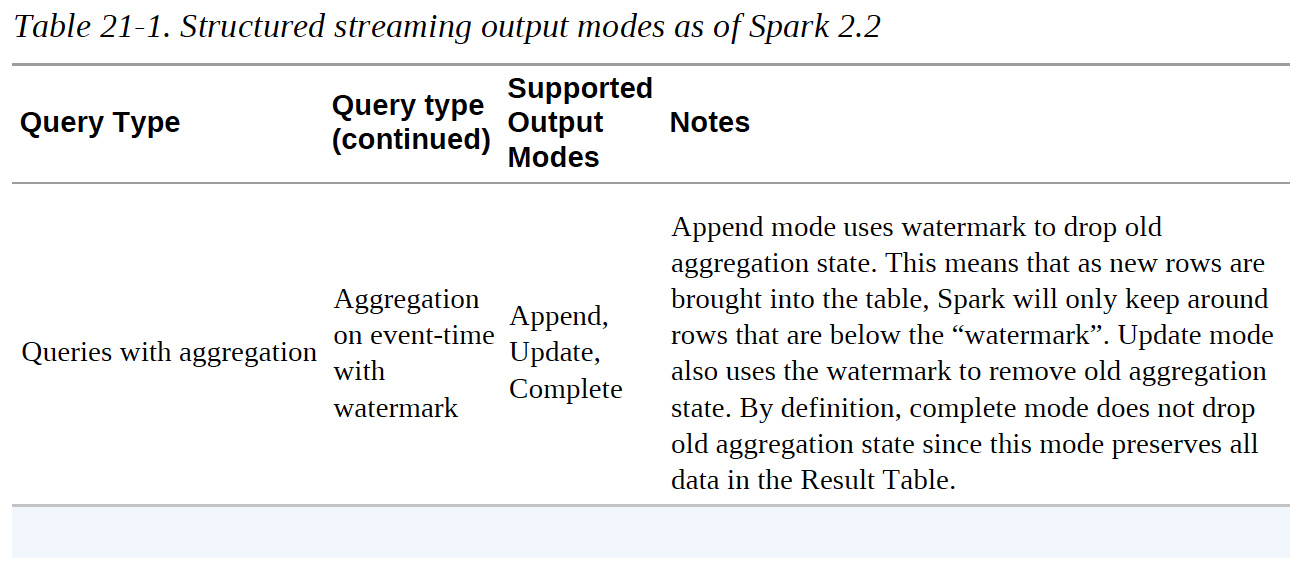
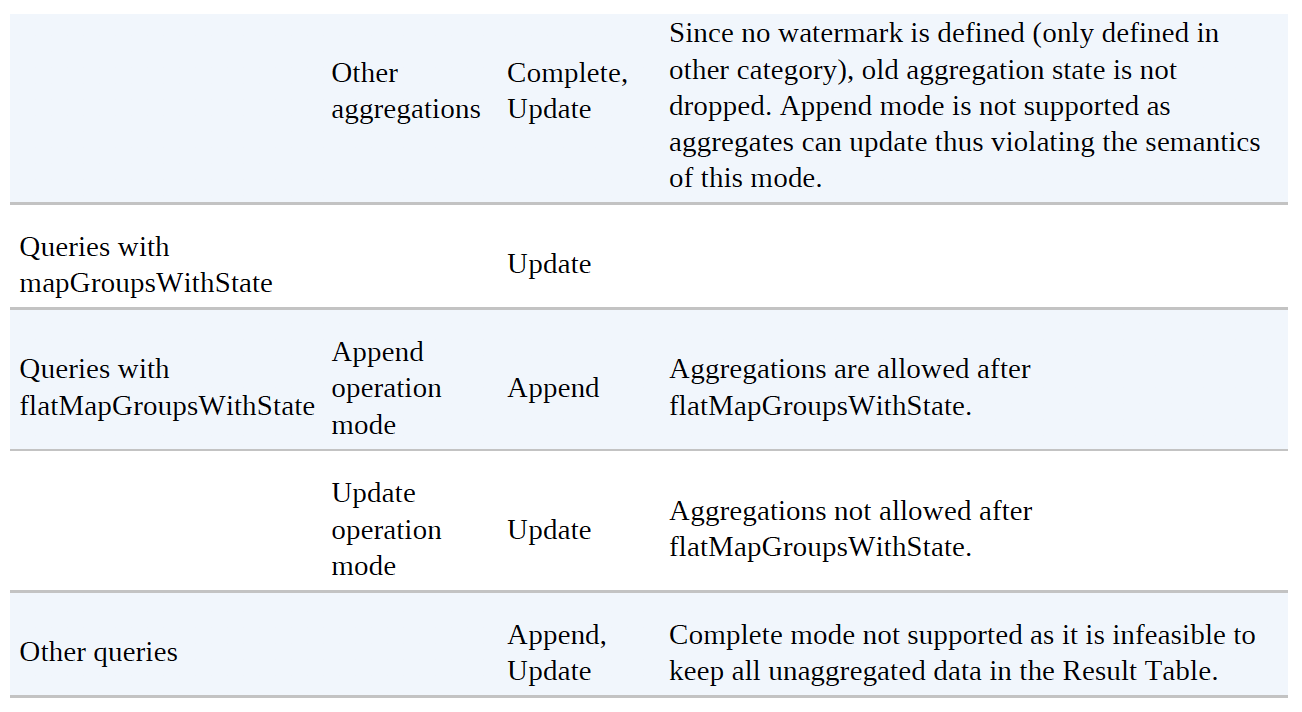

## When Data Is Output (Triggers)
Để kiểm soát thời điểm dữ liệu được xuất ra bồn rửa của chúng tôi, chúng tôi đặt một trình kích hoạt. Theo mặc định, Phát trực tuyến có cấu trúc
sẽ bắt đầu dữ liệu ngay khi trình kích hoạt trước đó hoàn tất quá trình xử lý. Bạn có thể sử dụng trình kích hoạt để
đảm bảo rằng bạn không làm ngập đầu ra của mình với quá nhiều bản cập nhật hoặc để thử và kiểm soát
kích thước tệp trong đầu ra. Hiện tại, có một loại trình kích hoạt định kỳ, dựa trên thời gian xử lý, như
cũng như trình kích hoạt “một lần” để chạy thủ công một bước xử lý một lần. Có thể sẽ có nhiều kích hoạt hơn
được thêm vào trong tương lai.
### Processing time trigger
Đối với trình kích hoạt thời gian xử lý, chúng tôi chỉ cần chỉ định khoảng thời gian dưới dạng chuỗi (bạn cũng có thể sử dụng
Thời lượng trong Scala hoặc TimeUnit trong Java). Chúng tôi sẽ hiển thị định dạng chuỗi bên dưới.

In [16]:
activityCounts.writeStream.trigger(processingTime='5 seconds')\
.format("console").outputMode("complete").start()

Trình kích hoạt Thời gian xử lý sẽ đợi bội số của khoảng thời gian nhất định để xuất dữ liệu.
Ví dụ: với thời lượng kích hoạt là một phút, trình kích hoạt sẽ kích hoạt lúc 12:00, 12:01, 12:02,
và như thế. Nếu thời gian kích hoạt bị bỏ lỡ do quá trình xử lý trước đó chưa hoàn tất, thì
Tia lửa sẽ đợi cho đến điểm kích hoạt tiếp theo (tức là phút tiếp theo), thay vì bắn ngay lập tức
sau khi quá trình trước đó hoàn tất.

### Once trigger
Bạn cũng có thể chỉ chạy một công việc phát trực tuyến một lần bằng cách đặt nó làm trình kích hoạt. Điều này có vẻ giống như một
trường hợp kỳ lạ, nhưng nó thực sự cực kỳ hữu ích trong cả quá trình phát triển và sản xuất. Suốt trong
phát triển, bạn có thể kiểm tra ứng dụng của mình trên chỉ một giá trị dữ liệu của trình kích hoạt tại một thời điểm. Suốt trong
sản xuất, trình kích hoạt Once có thể được sử dụng để chạy công việc của bạn theo cách thủ công với tốc độ thấp (ví dụ: nhập mới
dữ liệu vào một bảng tóm tắt chỉ thỉnh thoảng). Bởi vì Phát trực tuyến có cấu trúc vẫn theo dõi đầy đủ tất cả
các tệp đầu vào được xử lý và trạng thái tính toán, điều này dễ dàng hơn so với việc bạn tự viết
logic tùy chỉnh để theo dõi điều này trong một công việc hàng loạt và tiết kiệm rất nhiều tài nguyên khi chạy liên tục
công việc 24/7:

In [17]:
activityCounts.writeStream.trigger(once=True)\
.format("console").outputMode("complete").start()

# Phần kết luận
Rõ ràng là Phát trực tuyến có cấu trúc trình bày một cách mạnh mẽ để viết phát trực tuyến
các ứng dụng. Thực hiện một công việc hàng loạt bạn đã chạy và biến nó thành một công việc phát trực tuyến với gần như
không có thay đổi mã nào vừa đơn giản vừa cực kỳ hữu ích từ quan điểm kỹ thuật nếu bạn
cần phải có công việc này tương tác chặt chẽ với phần còn lại của ứng dụng xử lý dữ liệu của bạn.
Chương 22 đi sâu vào hai khái niệm liên quan đến phát trực tuyến nâng cao: xử lý thời gian sự kiện và
xử lý trạng thái. Sau đó, sau đó, Chương 23 đề cập đến những gì bạn cần làm để chạy có cấu trúc
Phân luồng trong sản xuất.